In [1]:
!pip install keras-segmentation

  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 3.3 MB 4.5 MB/s            
     |████████████████████████████████| 753 kB 63.4 MB/s            
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-py3-none-any.whl size=29070 sha256=9faf1f3c20c4bb35710355f74e461d8c6aaa0685788962a788f5bcc668c02da8
  Stored in directory: /root/.cache/pip/wheels/68/dc/b3/596a3e2461ba16e935ef31661c26e823f841cfb577cec4c47a
Successfully built keras-segmentation
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2.9.0
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.4.0
    Uninstalling imgaug-0.4.0:
      Successfully uninstalled imgaug-0.4.0


In [2]:
!pip install -U segmentation-models

     |████████████████████████████████| 50 kB 4.2 MB/s             


In [3]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn
import cv2 as cv
import nibabel as nib
import pickle
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm
import gc
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Multiply
from sklearn.model_selection import train_test_split
import keras_segmentation as ks

warnings.filterwarnings('ignore')
%matplotlib inline
print("Version: ", tf.version.VERSION)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "not available")

Version:  2.6.2
GPU is available


2022-02-27 06:54:23.672919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 06:54:23.795717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 06:54:23.796418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
metadata = pd.read_csv('../input/covid19-ct-scans/metadata.csv')
print(metadata.shape)
metadata.head()

(20, 4)


,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
4,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [5]:
img_size = 512

In [6]:
clahe = cv.createCLAHE(clipLimit=3.0)

def clahe_enhancer(img, clahe, axes):
    '''Contract Limited Adaptive Histogram Equalizer'''
    img = np.uint8(img*255)  
    clahe_img = clahe.apply(img)

    if len(axes) > 0 :    
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])

        axes[1].imshow(clahe_img, cmap='bone')
        axes[1].set_title("CLAHE Enhanced CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])

        if len(axes) > 2 :
            axes[2].hist(img.flatten(), alpha=0.4, label='Original CT scan')
            axes[2].hist(clahe_img.flatten(), alpha=0.4, label="CLAHE Enhanced CT scan")
            plt.legend()
        
    return(clahe_img)

Number of slices:  301


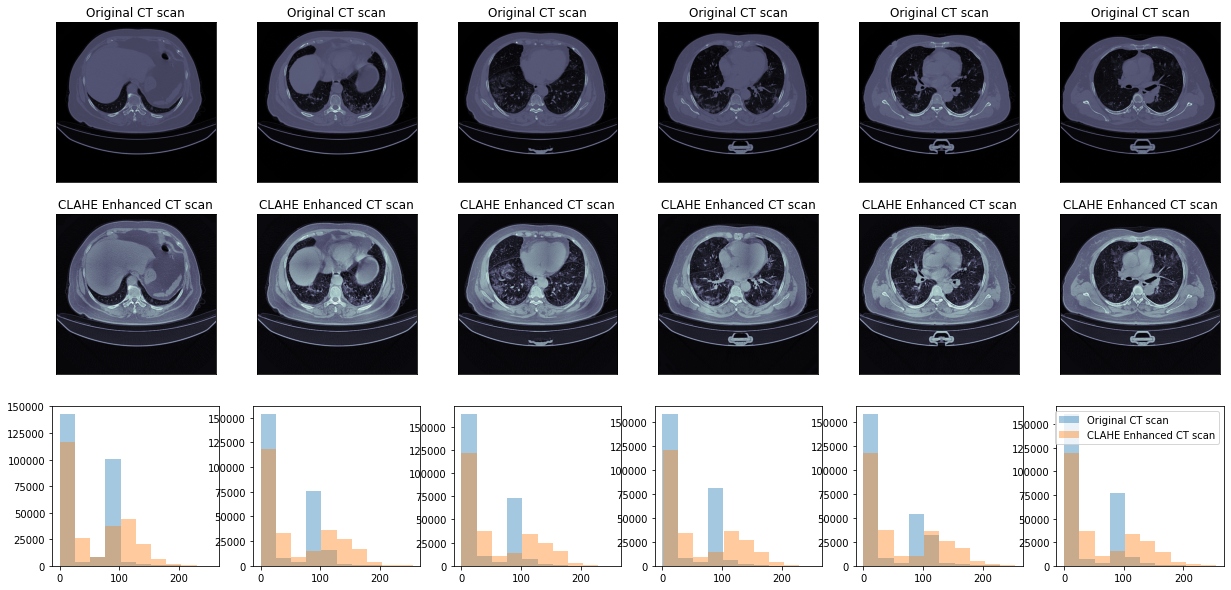

In [7]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
slices = cts.shape[2]
print('Number of slices: ', slices)
    
arr = cts.get_fdata()
arr = np.rot90(np.array(arr))
arr = arr[:,:,range(80,200,20)]
arr = np.reshape(np.rollaxis(arr, 2),(arr.shape[2],arr.shape[0],arr.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(21,10))    

for ii in range(arr.shape[0]):
    img = cv.resize(arr[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    clahe_img = clahe_enhancer(img, clahe, list(axes[:, ii]))

In [10]:
def get_contours(img):
    img = np.uint8(img*255)
    
    kernel = np.ones((3,3),np.float32)/9
    img = cv.filter2D(img, -1, kernel)
    
    ret, thresh = cv.threshold(img, 50, 255, cv.THRESH_BINARY)
    contours, hierarchy = cv.findContours(thresh, 2, 1)
    
    size = get_size(img)
    contours = [cc for cc in contours if contourOK(cc, size)]
    return contours

def get_size(img):
    ih, iw = img.shape
    return iw * ih

def contourOK(cc, size):
    x, y, w, h = cv.boundingRect(cc)
    if ((w < 50 and h > 150) or (w > 150 and h < 50)) : 
        return False # too narrow or wide is bad
    area = cv.contourArea(cc)
    return area < (size * 0.5) and area > 200

def find_boundaries(img, contours):
    # margin is the minimum distance from the edges of the image, as a fraction
    ih, iw = img.shape
    minx = iw
    miny = ih
    maxx = 0
    maxy = 0

    for cc in contours:
        x, y, w, h = cv.boundingRect(cc)
        if x < minx: minx = x
        if y < miny: miny = y
        if x + w > maxx: maxx = x + w
        if y + h > maxy: maxy = y + h

    return (minx, miny, maxx, maxy)

def crop_(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[miny:maxy, minx:maxx]
    
def crop_img(img, axes) :
    contours = get_contours(img)
    bounds = find_boundaries(img, contours)
    cropped_img = crop_(img, bounds)

    if len(axes) > 0 :
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])
        
        axes[1].imshow(cropped_img, cmap='bone')
        axes[1].set_title("Cropped CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])
        
    return cropped_img, bounds

Number of slices:  301


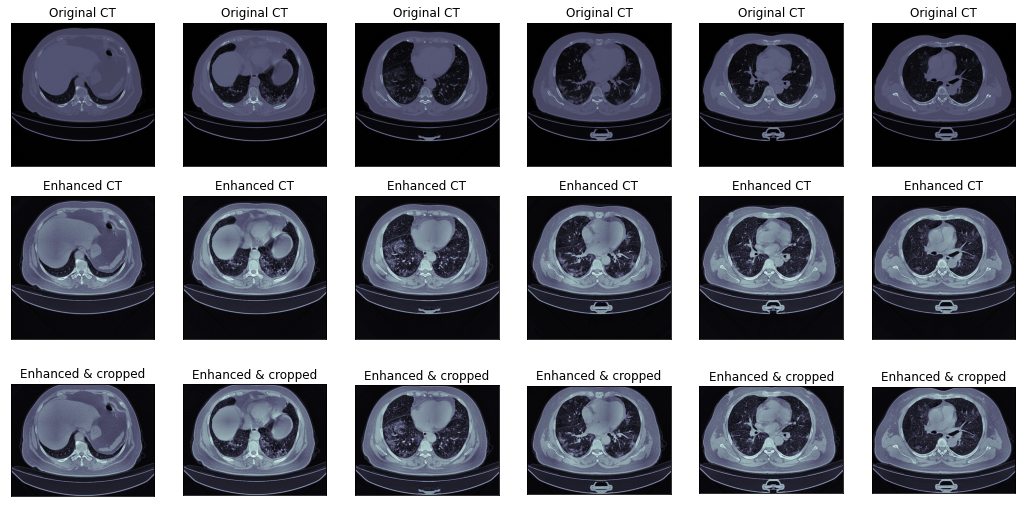

In [11]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
slices = cts.shape[2]
print('Number of slices: ', slices)
    
arr = cts.get_fdata()
arr = np.rot90(np.array(arr))
arr = arr[:,:,range(80,200,20)]
arr = np.reshape(np.rollaxis(arr, 2),(arr.shape[2],arr.shape[0],arr.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(18,9))    

for ii in range(arr.shape[0]):
    img = cv.resize(arr[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    _, bounds = crop_img(img, [])
    axes[0,ii].imshow(img, cmap='bone')
    axes[0,ii].set_title('Original CT')
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    clahe_img = clahe_enhancer(img, clahe, [])
    axes[1,ii].imshow(clahe_img, cmap='bone')
    axes[1,ii].set_title('Enhanced CT')
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])
    
    cropped_img = crop_(clahe_img, bounds)
    axes[2,ii].imshow(cropped_img, cmap='bone')
    axes[2,ii].set_title('Enhanced & cropped')
    axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])


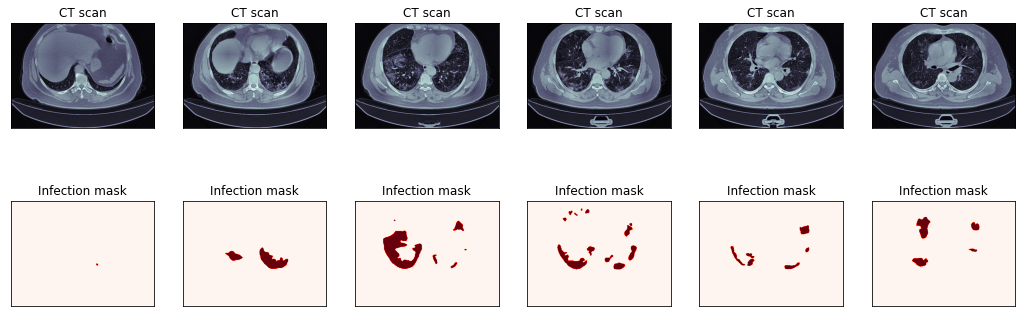

In [12]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
#lungs = nib.load(metadata.loc[0, 'lung_mask'])
infec = nib.load(metadata.loc[0, 'infection_mask'])
slices = cts.shape[2]
    
arr_cts = cts.get_fdata()
#arr_lungs = lungs.get_fdata()
arr_infec = infec.get_fdata()

arr_cts = np.rot90(np.array(arr_cts))
#arr_lungs = np.rot90(np.array(arr_lungs))
arr_infec = np.rot90(np.array(arr_infec))

arr_cts = arr_cts[:, :, range(80,200,20)]
#arr_lungs = arr_lungs[:, :, range(80,200,20)]
arr_infec = arr_infec[:, :, range(80,200,20)]

arr_cts = np.reshape(np.rollaxis(arr_cts, 2), 
                     (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
#arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2), 
                     #(arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
arr_infec = np.reshape(np.rollaxis(arr_infec, 2), 
                     (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1))

fig, axes = plt.subplots(2, 6, figsize=(18,6))    

for ii in range(arr_cts.shape[0]):
    img_ct = cv.resize(arr_cts[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    #img_lungs = cv.resize(arr_lungs[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    img_infec = cv.resize(arr_infec[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)

    #xmax, xmin = img_lungs.max(), img_lungs.min()
    #img_lungs = (img_lungs - xmin)/(xmax - xmin)
    #cropped_lungs, bounds = crop_img(img_lungs, [])
    
    xmax, xmin = img_ct.max(), img_ct.min()
    img_ct = (img_ct - xmin)/(xmax - xmin)
    clahe_ct = clahe_enhancer(img_ct, clahe, [])
    cropped_ct = crop_(clahe_ct, bounds)
    cropped_infec = crop_(img_infec, bounds)
    
    axes[0,ii].imshow(cropped_ct, cmap='bone')
    axes[0,ii].set_title("CT scan")
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    #axes[1,ii].imshow(cropped_lungs, cmap='Greens')
    #axes[1,ii].set_title("Lungs mask")
    #axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])

    axes[1,ii].imshow(cropped_infec, cmap='Reds')
    axes[1,ii].set_title("Infection mask")
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])

In [13]:
cts_all = []
#lungs_all = []
infects_all = []
max_w, max_h = 0, 0 #max width and height

for fnum in tqdm.tqdm(range(20)) : #range(metadata.shape[0])) :
    cts = nib.load(metadata.loc[fnum, 'ct_scan'])
    #lungs = nib.load(metadata.loc[fnum, 'lung_mask'])
    infec = nib.load(metadata.loc[fnum, 'infection_mask'])
    
    slices = cts.shape[2]

    arr_cts = cts.get_fdata()
    #arr_lungs = lungs.get_fdata()
    arr_infec = infec.get_fdata()

    arr_cts = np.rot90(np.array(arr_cts))
    #arr_lungs = np.rot90(np.array(arr_lungs))
    arr_infec = np.rot90(np.array(arr_infec))

    arr_cts = arr_cts[:, :, round(slices*0.2):round(slices*0.8)]
    #arr_lungs = arr_lungs[:, :, round(slices*0.2):round(slices*0.8)]
    arr_infec = arr_infec[:, :, round(slices*0.2):round(slices*0.8)]

    arr_cts = np.reshape(np.rollaxis(arr_cts, 2), 
                     (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
    #arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2), 
                    # (arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
    arr_infec = np.reshape(np.rollaxis(arr_infec, 2), 
                     (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1))
    
    for ii in range(arr_cts.shape[0]):
        #img_lungs = cv.resize(arr_lungs[ii], dsize=(img_size, img_size), 
                              #interpolation=cv.INTER_AREA)
        #xmax, xmin = img_lungs.max(), img_lungs.min()
        #img_lungs = (img_lungs - xmin)/(xmax - xmin)
        #cropped_lungs, bounds = crop_img(img_lungs, [])
        #lungs_all.append(cropped_lungs)
        
        h, w = cropped_img.shape
        max_h, max_w = max(max_h, h), max(max_w, w)

        img_ct = cv.resize(arr_cts[ii], dsize=(img_size, img_size), 
                           interpolation=cv.INTER_AREA)
        xmax, xmin = img_ct.max(), img_ct.min()
        img_ct = (img_ct - xmin)/(xmax - xmin)
        clahe_ct = clahe_enhancer(img_ct, clahe, [])
        cropped_ct = crop_(clahe_ct, bounds)
        cts_all.append(cropped_ct)

        img_infec = cv.resize(arr_infec[ii], dsize=(img_size, img_size), 
                              interpolation=cv.INTER_AREA)
        cropped_infec = crop_(img_infec, bounds)
        infects_all.append(cropped_infec)

100%|██████████| 20/20 [01:01<00:00,  3.09s/it]


In [14]:
print(len(cts_all))

2112


In [15]:
num_pix = 100
del_lst = []
for ii in tqdm.tqdm(range(len(cts_all))) :
    try :
        cts_all[ii] = cv.resize(cts_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        cts_all[ii] = np.reshape(cts_all[ii], (num_pix, num_pix, 1))

        #lungs_all[ii] = cv.resize(lungs_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        #lungs_all[ii] = np.reshape(lungs_all[ii], (num_pix, num_pix, 1))

        infects_all[ii] = cv.resize(infects_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        infects_all[ii] = np.reshape(infects_all[ii], (num_pix, num_pix, 1))
    except :
        del_lst.append(ii)
        
for idx in del_lst[::-1] :
    del cts_all[idx]
    #del lungs_all[idx]
    del infects_all[idx]

100%|██████████| 2112/2112 [00:01<00:00, 1065.60it/s]


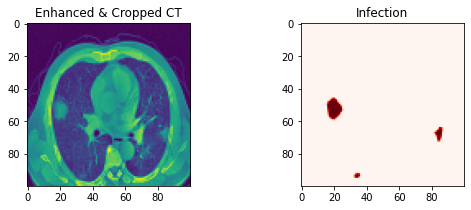

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(9,3))

axes[0].imshow(cts_all[250][:, :, 0])
axes[0].set_title("Enhanced & Cropped CT")

#axes[1].imshow(lungs_all[250][:, :, 0], cmap='Greens')
#axes[1].set_title("Lungs")

axes[1].imshow(infects_all[250][:, :, 0], cmap='Reds')
axes[1].set_title("Infection");

In [17]:
with open('preprocessed_cts.cp', 'wb') as myfile:
    pickle.dump({'cts_all': cts_all, 'infects_all': infects_all}, myfile)

In [18]:
infect_bool = np.ones((1, len(infects_all)))
for ii in range(len(infects_all)):
    if np.unique(infects_all[ii]).size == 1:
        infect_bool[0, ii] = 0
        
print("Number of CTs with no infection: %d" %(len(infects_all)-infect_bool.sum()))

#for index in sorted(no_masks, reverse = True):  
#    del infections[index]  
#    del cts[index]

Number of CTs with no infection: 498


In [19]:
ia.seed(1)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Flipud(0.5), # vertical flips
    
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-15, 15),
        shear=(-15, 15)
    )
], random_order=True) # apply augmenters in random order

In [20]:
num_augs = round(len(cts_all)/2.)
rand_idx = np.random.randint(0, len(cts_all), size=num_augs)

sample_cts = [cts_all[ii] for ii in rand_idx]
#sample_lungs = [lungs_all[ii] for ii in rand_idx]
sample_infects = [infects_all[ii] for ii in rand_idx]

In [21]:
seq_det = seq.to_deterministic()
cts_aug = seq_det.augment_images(sample_cts)
#lungs_aug = seq_det.augment_images(sample_lungs)
infects_aug = seq_det.augment_images(sample_infects)

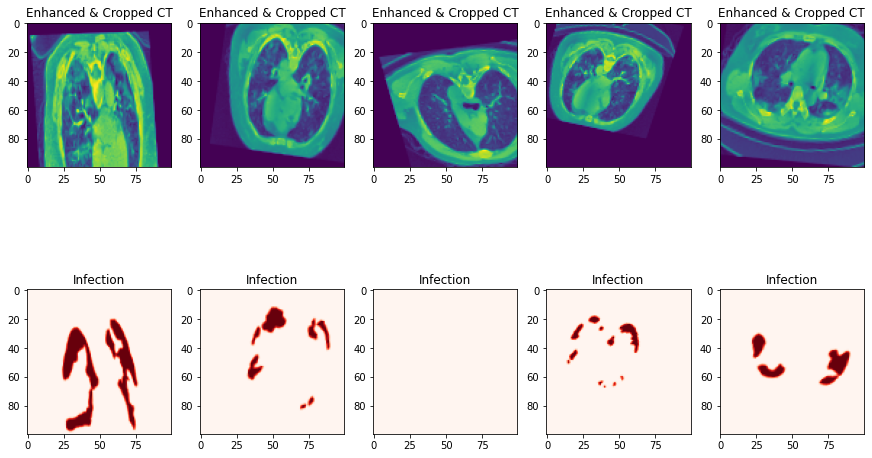

In [22]:
fig, axes = plt.subplots(2, 5, figsize=(15,9))

for ii in range(5) :
    axes[0, ii].imshow(cts_aug[ii*10+50][:, :, 0])
    axes[0, ii].set_title("Enhanced & Cropped CT")

    #axes[1, ii].imshow(lungs_aug[ii*10+50][:, :, 0], cmap='Greens')
    #axes[1, ii].set_title("Lungs")

    axes[1, ii].imshow(infects_aug[ii*10+50][:, :, 0], cmap='Reds')
    axes[1, ii].set_title("Infection");

In [23]:
cts_all = tf.convert_to_tensor(cts_all)
cts_aug = tf.convert_to_tensor(cts_aug)
#lungs_all = tf.convert_to_tensor(lungs_all)
#lungs_aug = tf.convert_to_tensor(lungs_aug)
infects_all = tf.convert_to_tensor(infects_all)
infects_aug = tf.convert_to_tensor(infects_aug)

cts = tf.concat([cts_all, cts_aug], axis=0)
#lungs = tf.concat([lungs_all, lungs_aug], axis=0)
infects = tf.concat([infects_all, infects_aug], axis=0)

2022-02-27 06:57:12.083996: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-27 06:57:12.084817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 06:57:12.085739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 06:57:12.086437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [25]:
indices = tf.range(start=0, limit=cts.shape[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)
                       
cts = tf.gather(cts, shuffled_indices)
#lungs = tf.gather(lungs, shuffled_indices)
infects = tf.gather(infects, shuffled_indices)

print(cts.shape, infects.shape)

(3168, 100, 100, 1) (3168, 100, 100, 1)


In [26]:
with open('augmented_cts.cp', 'wb') as myfile:
    pickle.dump({'cts': cts, 'infects': infects}, myfile)

In [27]:
## see https://github.com/keras-team/keras/issues/9395

def dice_coeff(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred): #Binary Cross-Entropy
    loss = 0.5*losses.binary_crossentropy(y_true, y_pred) + 0.5*dice_loss(y_true, y_pred)
    return loss

def tversky_loss(y_true, y_pred):
    alpha, beta  = 0.5, 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred
    p1 = ones-y_pred
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) 
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + 
                     K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1*m2)
    score = (2.*K.sum(w*intersection) + smooth) / (K.sum(w*m1) + K.sum(w*m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    averaged_mask = K.pool2d(y_true, pool_size=(50, 50), strides=(1, 1), 
                             padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5.*K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 0.5*weighted_bce_loss(y_true, y_pred, weight) + 0.5*dice_loss(y_true, y_pred)
    return loss

In [28]:
# define custom learning rate schedule
class CosineAnnealingLearningRateSchedule(callbacks.Callback):
    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()
 
    # calculate learning rate for an epoch
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = np.floor(n_epochs/n_cycles)
        cos_inner = (np.pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_max/2 * (np.cos(cos_inner) + 1)
 
    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs=None):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
        # set learning rate
        K.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrates.append(lr)

In [29]:
# define learning rate callback
n_epochs = 200
lrmax = 0.002
n_cycles = n_epochs / 25
lr_cb = CosineAnnealingLearningRateSchedule(n_epochs, n_cycles, lrmax)

In [30]:
def cts_block_1 (x_in, conv2Dfilters, maxpool2Dsize=(2,2)) :
    x = Conv2D(conv2Dfilters, (3,3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x_in)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x)
    x_inter = BatchNormalization() (x)
    x = MaxPooling2D(maxpool2Dsize) (x_inter) 
    x = Dropout(0.25)(x) 
    
    return x, x_inter

def cts_block_2 (x_in, conv2Dfilters) :
    x = BatchNormalization() (x_in)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x)
    x = Conv2D(conv2Dfilters, (3, 3), activation='relu', padding='same', 
               kernel_initializer="he_normal") (x) 
    
    return x

In [31]:
def cts_model (input_shape) :
    
    x_input = Input(input_shape)
    
    ##################################  LUNG SEGMENTATION  ######################
  

    ##################################  INFECTION SEGMENTATION  ######################
    ##################################  INFECTION SEGMENTATION  ######################
    x, x1 = cts_block_1 ( x_input, 32, maxpool2Dsize=(2,2)) #x: 50x50
    x, x2 = cts_block_1 (x, 64, maxpool2Dsize=(2,2)) #x: 25x25
    x, _ = cts_block_1 (x, 128, maxpool2Dsize=(1,1)) #x: 25x25
    x, _ = cts_block_1 (x, 256, maxpool2Dsize=(1,1)) #x: 25x25
    
    x = cts_block_2 (x, 256) #x: 25x25
    
    x = Conv2DTranspose(128, (2, 2), strides=(2,2), padding='same') (x) #x: 50x50
    x = cts_block_2 (x, 128) #x: 50x50

    x = Conv2DTranspose(64, (2, 2), padding='same') (x) #x: 50x50
    x = concatenate([x, x2]) #x: 50x50
    x = cts_block_2 (x, 64) #x: 50x50

    x = Conv2DTranspose(32, (2, 2), strides=(2,2), padding='same') (x) #x: 100x100
    x = concatenate([x, x1], axis=3) #x: 100x100
    x = cts_block_2 (x, 32) #x: 100x100

    infect_seg = Conv2D(1, (1, 1), activation='sigmoid', name='infect_output') (x) # identifying infections
    
   
    model = Model(inputs=x_input, outputs=[infect_seg], name='cts_model')
    
    return model

In [32]:
ctsModel = cts_model(cts.shape[1:])
ctsModel.summary()

Model: "cts_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 100, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 100, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________

In [33]:
train_size = int(0.8*cts.shape[0])
test_size = int(0.1*cts.shape[0])

X_train, yi_train = (cts[:train_size]/255,  
                               infects[:train_size])

X_valid, yi_valid = (cts[train_size:train_size+test_size]/255, 
                               infects[train_size:train_size+test_size])

X_test, yi_test = (cts[train_size+test_size:]/255, 
                            infects[train_size+test_size:])

print(X_train.shape, yi_train.shape)
print(X_test.shape, yi_test.shape)

(2534, 100, 100, 1) (2534, 100, 100, 1)
(318, 100, 100, 1) (318, 100, 100, 1)


In [34]:
batch_size = 128
epochs = n_epochs

checkpoint_fpath = "ctsmodel-lungs-seg.hdf5"
cts_checkpoint_cb = callbacks.ModelCheckpoint(checkpoint_fpath, 
                                              monitor='val_infect_output_dice_coeff', 
                                              save_best_only=True, 
                                              mode='max', 
                                              verbose=1,
                                              save_weights_only=True)

In [ ]:
#keras.optimizers.Adam

In [35]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow import keras
optim = keras.optimizers.Adam(lr=1e-3, beta_1=0.9, beta_2=0.99)

loss_dict = { 'infect_output': bce_dice_loss}
loss_weight_dict = {'infect_output': 1.0}

ctsModel.compile(optimizer=optim, loss=loss_dict, loss_weights=loss_weight_dict, metrics=[dice_coeff])

ctsRes = ctsModel.fit(x=X_train, 
                      y={ 'infect_output': yi_train}, 
                      batch_size=batch_size, 
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_valid, 
                                       {'infect_output': yi_valid}),
                      callbacks = [cts_checkpoint_cb, lr_cb])

2022-02-27 06:59:26.595631: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2022-02-27 06:59:29.102494: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


20/20 [==============================] - 20s 493ms/step - loss: 0.5239 - dice_coeff: 0.1046 - val_loss: 0.8621 - val_dice_coeff: 0.0187
Epoch 2/200
20/20 [==============================] - 6s 297ms/step - loss: 0.3989 - dice_coeff: 0.2871 - val_loss: 1.0556 - val_dice_coeff: 0.0886
Epoch 3/200
20/20 [==============================] - 6s 299ms/step - loss: 0.3099 - dice_coeff: 0.4681 - val_loss: 1.0011 - val_dice_coeff: 0.1796
Epoch 4/200
20/20 [==============================] - 6s 296ms/step - loss: 0.2518 - dice_coeff: 0.5722 - val_loss: 0.9057 - val_dice_coeff: 0.1106
Epoch 5/200
20/20 [==============================] - 6s 298ms/step - loss: 0.2261 - dice_coeff: 0.6124 - val_loss: 0.7313 - val_dice_coeff: 0.1379
Epoch 6/200
20/20 [==============================] - 6s 297ms/step - loss: 0.2090 - dice_coeff: 0.6447 - val_loss: 0.9333 - val_dice_coeff: 0.1599
Epoch 7/200
20/20 [==============================] - 6s 296ms/step - loss: 0.2068 - dice_coeff: 0.6500 - val_loss: 0.6341 - val_d

In [36]:
ctsModel.save('model_infection_mask.h5')

In [37]:
score = ctsModel.evaluate(X_test, yi_test, verbose=2)
print("Dice Loss, Dice coefficient:", score)

10/10 - 2s - loss: 0.0907 - dice_coeff: 0.8416
Dice Loss, Dice coefficient: [0.09069237858057022, 0.8415783047676086]


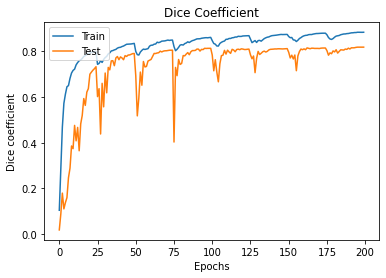

In [38]:
plt.plot(ctsRes.history['dice_coeff'])
plt.plot(ctsRes.history['val_dice_coeff'])
plt.title('Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice coefficient')
plt.legend(['Train', 'Test'], loc = 'upper left')
plt.show()

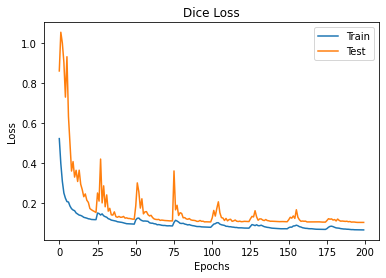

In [39]:
plt.plot(ctsRes.history['loss'])
plt.plot(ctsRes.history['val_loss'])
plt.title('Dice Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc = 'upper right')
plt.show()

In [40]:
# Restore the weights
ctsModel.load_weights('./model_infection_mask.h5')

# Evaluate the model
loss, acc =ctsModel.evaluate(X_test, yi_test, verbose=2)
print("Restored model, Dice Coefficient: {:5.2f}%".format(100 * acc))

10/10 - 0s - loss: 0.0907 - dice_coeff: 0.8416
Restored model, Dice Coefficient: 84.16%


In [41]:
ctsModel_json = ctsModel.to_json()
with open('ctsModel-infects.json', 'w') as myfile:
     myfile.write(ctsModel_json)

In [42]:
yi_pred = ctsModel.predict(X_test)
print(yi_pred.shape)

(318, 100, 100, 1)


In [43]:
len(X_test)

318

# Compare Actual infection and predicted infection

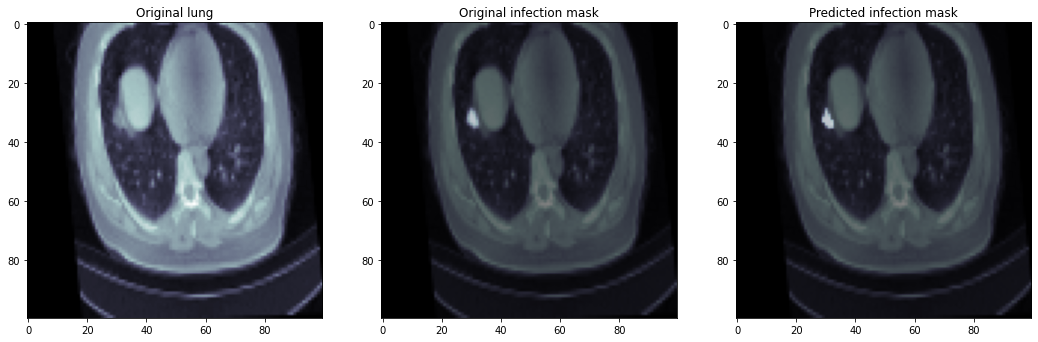

In [44]:
predicted = ctsModel.predict(X_test)
fig = plt.figure(figsize = (18,15))


for i in range(len(X_test)):
    #i=100
    plt.subplot(1,3,1)
    plt.imshow(X_test[i][...,0], cmap = 'bone')
    plt.title('Original lung')

    plt.subplot(1,3,2)
    plt.imshow(X_test[i][...,0], cmap = 'bone')
    plt.imshow(yi_test[i][...,0],alpha = 0.5, cmap = "bone")
    plt.title('Original infection mask')

    plt.subplot(1,3,3)
    plt.imshow(X_test[i][...,0], cmap = 'bone')
    plt.imshow(predicted[i][...,0],alpha = 0.5,cmap = "bone")
    plt.title('Predicted infection mask')

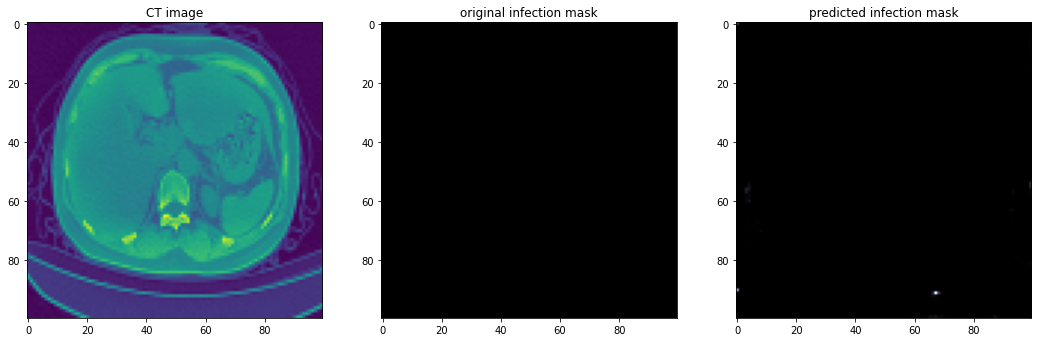

In [45]:
def compare_actual_and_predicted(img_num):

    fig = plt.figure(figsize=(18,15))
    for i in range(len(X_test)):
        plt.subplot(2,3,1)
        plt.imshow(tf.reshape(X_test[img_num], [num_pix, num_pix]))
        plt.title('CT image')

        plt.subplot(2,3,2)
        plt.imshow(tf.reshape(yi_test[img_num], [num_pix, num_pix]), cmap='bone')
        plt.title('original infection mask')

    #plt.subplot(2,3,3)
    #plt.imshow(tf.reshape(yi_test[img_num], [num_pix, num_pix]), cmap='bone')
    #plt.title('infection mask')

        plt.subplot(2,3,3)
        plt.imshow(tf.reshape(yi_pred[img_num], [num_pix, num_pix]), cmap='bone')
        plt.title('predicted infection mask')

    

compare_actual_and_predicted(59)

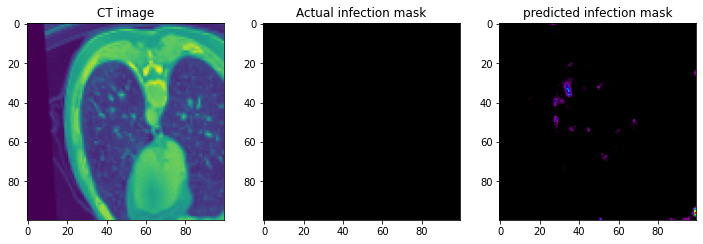

In [46]:
def compare_actual_and_predicted(img_num):

    fig = plt.figure(figsize=(12,12))

    plt.subplot(2,3,1)
    plt.imshow(tf.reshape(X_test[img_num], [num_pix, num_pix]))
    plt.title('CT image')

    plt.subplot(2,3,2)
    plt.imshow(tf.reshape(yi_test[img_num], [num_pix, num_pix]), cmap='nipy_spectral')
    plt.title('Actual infection mask')

    #plt.subplot(2,3,3)
    #plt.imshow(tf.reshape(yi_test[img_num], [num_pix, num_pix]), cmap='bone')
    #plt.title('infection mask')

    plt.subplot(2,3,3)
    plt.imshow(tf.reshape(yi_pred[img_num], [num_pix, num_pix]), cmap='nipy_spectral')
    plt.title('predicted infection mask')

   # plt.subplot(2,3,6)
   # plt.imshow(tf.reshape(yi_pred[img_num], [num_pix, num_pix]), cmap='bone')
    #plt.title('predicted infection mask')
    

compare_actual_and_predicted(55)

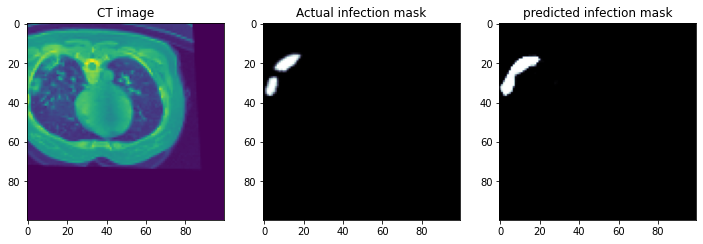

In [47]:
def compare_actual_and_predicted(img_num):

    fig = plt.figure(figsize=(12,12))

    plt.subplot(2,3,1)
    plt.imshow(tf.reshape(X_test[img_num], [num_pix, num_pix]))
    plt.title('CT image')

    plt.subplot(2,3,2)
    plt.imshow(tf.reshape(yi_test[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('Actual infection mask')

    

    plt.subplot(2,3,3)
    plt.imshow(tf.reshape(yi_pred[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('predicted infection mask')

   
    

compare_actual_and_predicted(48)

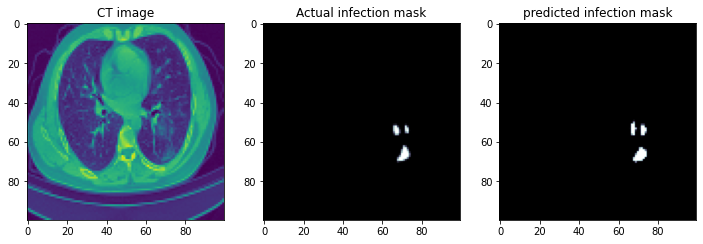

In [48]:
def compare_actual_and_predicted(img_num):

    fig = plt.figure(figsize=(12,12))

    plt.subplot(2,3,1)
    plt.imshow(tf.reshape(X_test[img_num], [num_pix, num_pix]))
    plt.title('CT image')

    plt.subplot(2,3,2)
    plt.imshow(tf.reshape(yi_test[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('Actual infection mask')

    

    plt.subplot(2,3,3)
    plt.imshow(tf.reshape(yi_pred[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('predicted infection mask')

   
    

compare_actual_and_predicted(60)

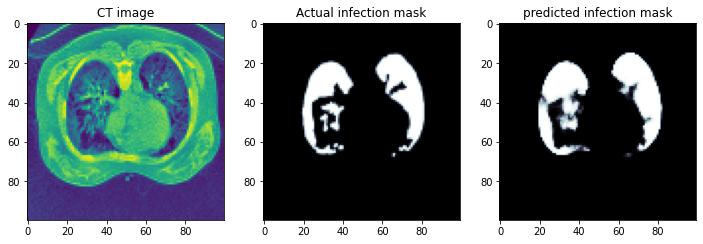

In [49]:
def compare_actual_and_predicted(img_num):

    fig = plt.figure(figsize=(12,12))

    plt.subplot(2,3,1)
    plt.imshow(tf.reshape(X_test[img_num], [num_pix, num_pix]))
    plt.title('CT image')

    plt.subplot(2,3,2)
    plt.imshow(tf.reshape(yi_test[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('Actual infection mask')

    

    plt.subplot(2,3,3)
    plt.imshow(tf.reshape(yi_pred[img_num], [num_pix, num_pix]), cmap='bone')
    plt.title('predicted infection mask')

   
    

compare_actual_and_predicted(153)

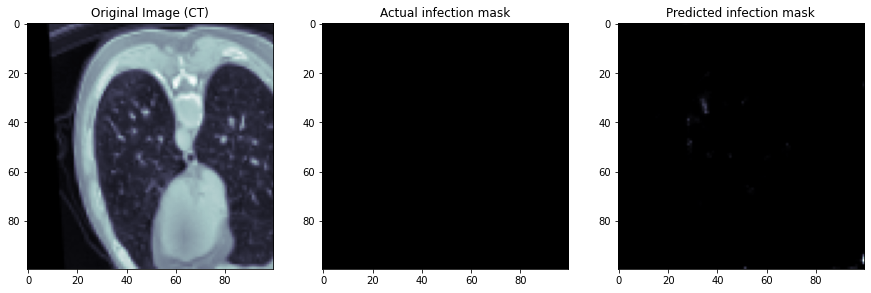

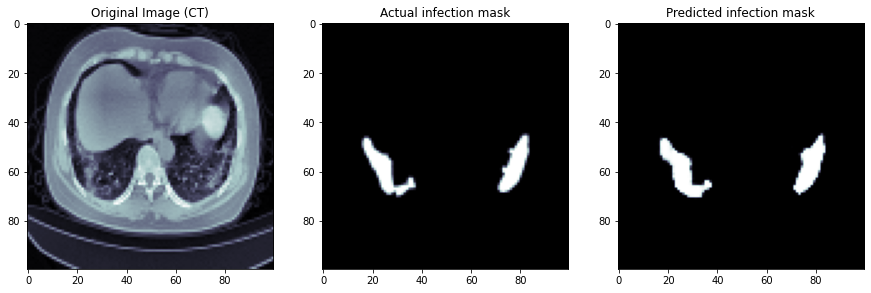

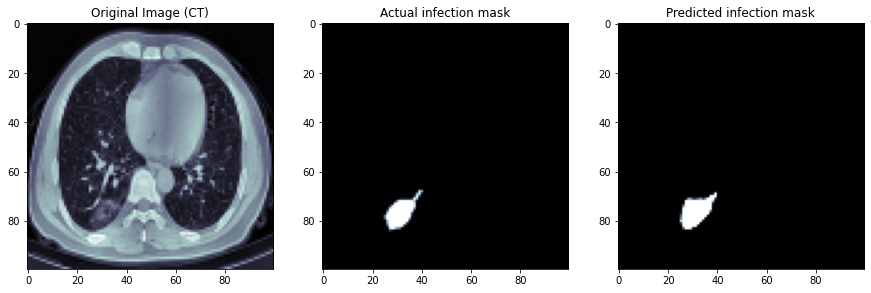

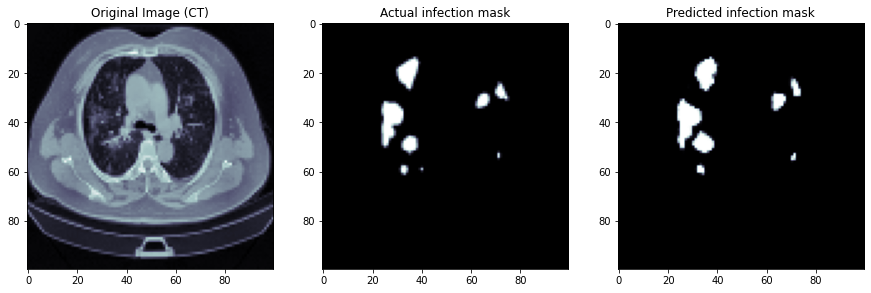

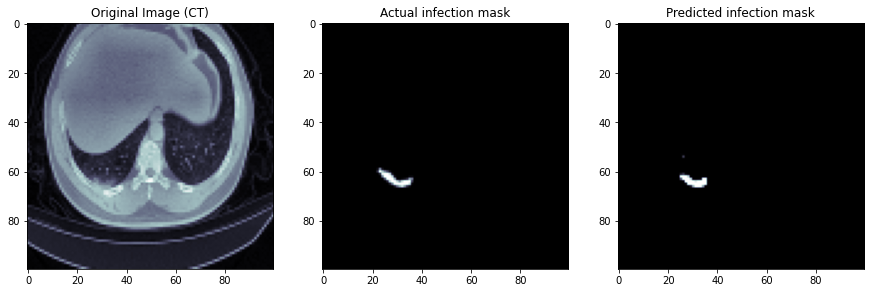

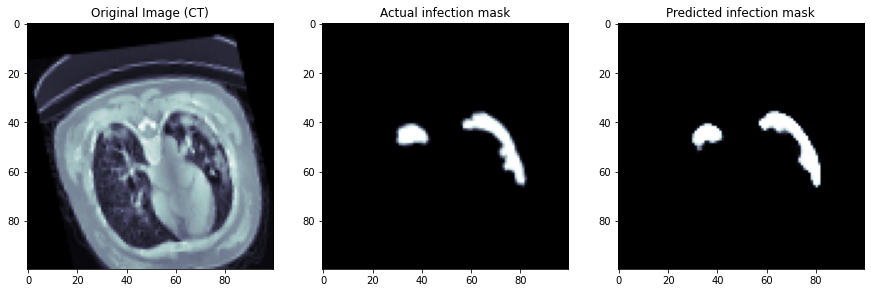

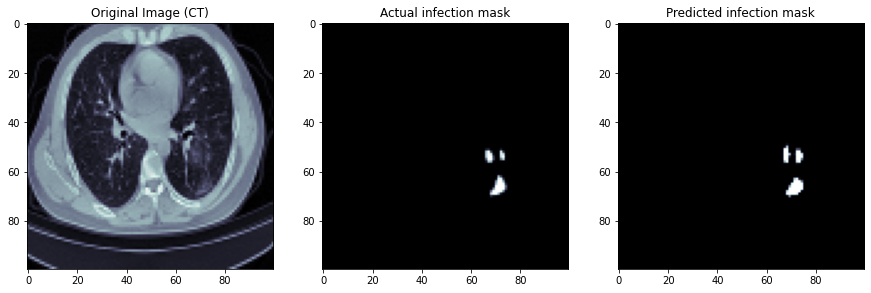

In [50]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
def compare_actual_and_predicted(img_num):
    temp = ctsModel.predict(X_test[img_num].reshape(1,num_pix, num_pix,1))

    fig = plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    plt.imshow(X_test[img_num].reshape(num_pix, num_pix), cmap='bone')
    plt.title('Original Image (CT)')

    plt.subplot(1,3,2)
    plt.imshow(yi_test[img_num].reshape(num_pix, num_pix), cmap='bone')
    plt.title('Actual infection mask')

    plt.subplot(1,3,3)
    plt.imshow(temp.reshape(num_pix, num_pix), cmap='bone')
    plt.title('Predicted infection mask')

    plt.show()
for i in [55,269,155, 255, 165, 90,60]:
    compare_actual_and_predicted(i)  

# Evaluation Metrics


In [51]:
the_range = np.arange(0.10,0.80, 0.05)

In [52]:
import segmentation_models as sm

dices=[]
ious=[]

for t in the_range:
    iou = sm.metrics.IOUScore(threshold=t)
    dice = sm.metrics.FScore(threshold=t)
    ctsModel.compile(optimizer=Adam(lr = 0.002), loss=bce_dice_loss, metrics=[dice, iou])
    score = ctsModel.evaluate(X_test, yi_test, batch_size=32) 
    dices.append(score[1])
    ious.append(score[2])

Segmentation Models: using `keras` framework.
10/10 [==============================] - 1s 24ms/step - loss: 0.0907 - f1-score: 0.8336 - iou_score: 0.7149


In [53]:
#import segmentation_models as sm

dices=[]
ious=[]

for t in the_range:
    iou = sm.metrics.IOUScore(threshold=t)
    dice = sm.metrics.FScore(threshold=t)
    ctsModel.compile(optimizer=Adam(lr = 0.002), loss=bce_dice_loss, metrics=[dice, iou])
    score = ctsModel.evaluate(X_test, yi_test, batch_size=32) #X_test, yl_test
    dices.append(score[1])
    ious.append(score[2])

10/10 [==============================] - 1s 25ms/step - loss: 0.0907 - f1-score: 0.8336 - iou_score: 0.7149


In [54]:
print('DICES:',dices)
print("IOUS:",ious)
print("Best Threshold:", the_range[np.argmax(dices)])
print("Best dice score:", dices[np.argmax(dices)])
print("Best iou score:", ious[np.argmax(ious)])

DICES: [0.8306620717048645, 0.8327280282974243, 0.8343247175216675, 0.8351256251335144, 0.835599422454834, 0.8359896540641785, 0.8361924886703491, 0.8360182642936707, 0.835976243019104, 0.8359773755073547, 0.8359056711196899, 0.8356434106826782, 0.8347962498664856, 0.8336326479911804]
IOUS: [0.71063631772995, 0.7136398553848267, 0.7159713506698608, 0.717131495475769, 0.7178192734718323, 0.7183784246444702, 0.7186726927757263, 0.7184197306632996, 0.7183583378791809, 0.7183570861816406, 0.7182430028915405, 0.7178493142127991, 0.7166014909744263, 0.7148881554603577]
Best Threshold: 0.40000000000000013
Best dice score: 0.8361924886703491
Best iou score: 0.7186726927757263


Best Threshold: 0.40000000000000013


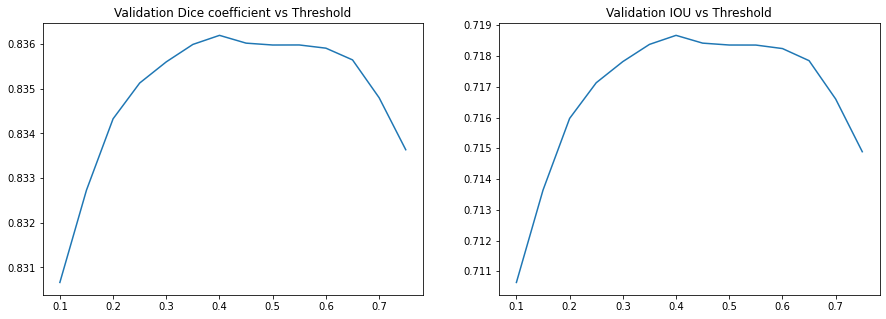

In [55]:
print("Best Threshold:", the_range[np.argmax(dices)])
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(the_range, dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(the_range, ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [56]:
the_new_range = np.arange(0.30,0.40, 0.001)

In [57]:
new_dices=[]
new_ious=[]

for t in the_new_range:
    iou = sm.metrics.IOUScore(threshold=t)
    dice = sm.metrics.FScore(threshold=t)
    ctsModel.compile(optimizer=Adam(lr = 0.002), loss=bce_dice_loss, metrics=[dice, iou])
    score = ctsModel.evaluate(X_test, yi_test, batch_size=32)
    new_dices.append(score[1])
    new_ious.append(score[2])

10/10 [==============================] - 1s 26ms/step - loss: 0.0907 - f1-score: 0.8362 - iou_score: 0.7187


In [58]:
print("We just checked for",len(the_new_range), "steps between 0.30 and 0.40")

We just checked for 101 steps between 0.30 and 0.40


In [59]:
print('NEW DICES:',new_dices)
print("NEW IOUS:",new_ious)
print("New Best Threshold:", the_new_range[np.argmax(new_dices)])
print("Best new dice score:", new_dices[np.argmax(new_dices)])
print("Best new iou score:", new_ious[np.argmax(new_ious)])

NEW DICES: [0.835599422454834, 0.8355838656425476, 0.8355394601821899, 0.835582435131073, 0.8355984687805176, 0.8356377482414246, 0.8356631398200989, 0.8356706500053406, 0.8356667757034302, 0.8356777429580688, 0.8357046246528625, 0.8356866836547852, 0.8356944918632507, 0.8357216119766235, 0.8357059359550476, 0.8357114791870117, 0.8357186317443848, 0.8357319831848145, 0.8357644081115723, 0.8357449769973755, 0.835732102394104, 0.8357464075088501, 0.835771381855011, 0.8357945680618286, 0.8357760310173035, 0.8357839584350586, 0.8357618451118469, 0.8357946276664734, 0.8357927203178406, 0.8357506990432739, 0.8357197046279907, 0.8357613682746887, 0.8357758522033691, 0.8357345461845398, 0.8357136845588684, 0.8357497453689575, 0.8357819318771362, 0.8358249664306641, 0.8358741998672485, 0.8359116315841675, 0.8359554409980774, 0.8359444737434387, 0.8359635472297668, 0.8359733819961548, 0.8359556198120117, 0.8359673619270325, 0.8359881639480591, 0.8359716534614563, 0.8359875679016113, 0.8359912633

Best Threshold: 0.4000000000000001


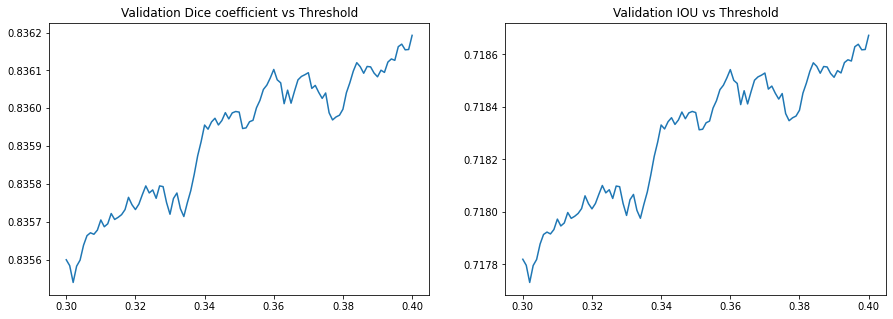

In [60]:
print("Best Threshold:", the_new_range[np.argmax(new_dices)])
fig = plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(the_new_range, new_dices)
plt.title("Validation Dice coefficient vs Threshold")

plt.subplot(1, 2, 2)
plt.plot(the_new_range, new_ious)
plt.title("Validation IOU vs Threshold")

plt.show()

In [61]:
the_prec_rec_range = np.arange(0,1, 0.05)

In [62]:
precisions=[]
recalls=[]

for t in the_prec_rec_range:
    precision = sm.metrics.Precision(threshold=t)
    recall = sm.metrics.Recall(threshold=t)
    ctsModel.compile(optimizer=Adam(lr = 0.002), loss=bce_dice_loss, metrics=[precision, recall])
    score = ctsModel.evaluate(X_test, yi_test, batch_size=32)
    precisions.append(score[1])
    recalls.append(score[2])

10/10 [==============================] - 1s 24ms/step - loss: 0.0907 - precision: 0.8946 - recall: 0.7511


In [63]:
print('PRECISIONS:',precisions)
print("RRECALLS:",recalls)
print("Best Threshold for Precision:", the_prec_rec_range[np.argmax(precisions)])
print("Best Threshold for Recall:", the_prec_rec_range[np.argmax(recalls)])
print("Best precision score:", precisions[np.argmax(precisions)])
print("Best recall score:", recalls[np.argmax(recalls)])

PRECISIONS: [0.016697470098733902, 0.7607353925704956, 0.7843634486198425, 0.7959381937980652, 0.8044232130050659, 0.8104976415634155, 0.8160365223884583, 0.8208054304122925, 0.8253666758537292, 0.8294845819473267, 0.8334778547286987, 0.8377184867858887, 0.8421382904052734, 0.8465363383293152, 0.8512269854545593, 0.855841338634491, 0.8613933324813843, 0.8684102892875671, 0.8781210780143738, 0.8946264982223511]
RRECALLS: [1.0, 0.8993738293647766, 0.8838337063789368, 0.8740997314453125, 0.8675354719161987, 0.8622831106185913, 0.8570982813835144, 0.852705180644989, 0.848259449005127, 0.8436012268066406, 0.839413046836853, 0.8351772427558899, 0.8306977152824402, 0.8259384036064148, 0.8198986053466797, 0.8134821057319641, 0.8057324290275574, 0.7955667972564697, 0.7800318002700806, 0.7511447072029114]
Best Threshold for Precision: 0.9500000000000001
Best Threshold for Recall: 0.0
Best precision score: 0.8946264982223511
Best recall score: 1.0


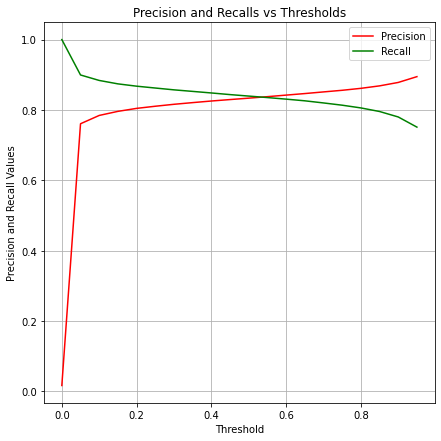

In [64]:
from pylab import rcParams
rcParams['figure.figsize'] = 7,7
plt.rcParams["axes.grid"] = True
plt.title("Precision and Recalls vs Thresholds")
plt.xlabel('Threshold')
plt.ylabel('Precision and Recall Values')
plt.plot(the_prec_rec_range,precisions, color='red')
plt.plot(the_prec_rec_range, recalls, color='green')
plt.legend(['Precision', 'Recall'])

In [66]:
cts_model

<function __main__.cts_model(input_shape)>

In [85]:
from keras.utils.generic_utils import get_custom_objects

get_custom_objects().update({'bce_dice_loss': bce_dice_loss})
get_custom_objects().update({'dice_coeff': dice_coeff})

In [86]:
import tensorflow as tf
model=tf.keras.models.load_model("./model_infection_mask.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open("infected_mask_u_net_model.tflite", "wb").write(tflite_model) 

2022-02-27 07:46:56.175698: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-02-27 07:47:00.950192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 07:47:00.950600: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-02-27 07:47:00.950769: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-02-27 07:47:00.951246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-27 07:47:00.951690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had ne

11857232